In [1]:
def allocateGPU(dgx = False):
    import subprocess
    import os
    import time
    while True:
        if dgx:
            result = subprocess.run(["/AvailableGPU/available_gpu", "-m", "15000"], stdout=subprocess.PIPE)
        else:
            result = subprocess.run(["/AvailableGPU/available_gpu", "-m", "10000"], stdout=subprocess.PIPE)
        try:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(int(result.stdout))
            print("Memory to be allocated in GPU ", str(int(result.stdout)))
            break
        except:
            print("No GPU available! Waiting (10 seconds)...")
            time.sleep(10)
allocateGPU()

Memory to be allocated in GPU  2


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

from skimage.transform import resize as sk_res
import matplotlib.pyplot as plt
import os
import random
import cv2
import numpy as np
import shutil
import sys
sys.path.extend(['/home/zadiq/dev/salt', 
                 '/home/zadiq/dev/competitions/salt', 
                 '/home/zoguntim/dev/s9043nfqhq89gh423qhjbfu89b4tj1qbfug8943'])

from tgs.layers import SigmoidThreshold
from tgs.models import unet_static
from tgs.metrics import (
    iou, map_iou, get_map_loss, 
    weight_loss_wrapper, get_map_iou_at,
    slow_map_iou
)

%matplotlib inline

Using TensorFlow backend.


In [3]:
IMG_SHAPE = (101, 101, 1)
TRAIN_IMG_SHAPE = (128, 128, 1)
ORIG_SIZE = 101
RES_SIZE = 128
DATA_BASE_DIR = '/media/zadiq/ZHD/datasets/salt'
SEED = 8090

In [4]:
def resize(img):
    print(img.shape)
    if ORIG_SIZE == RES_SIZE:
        return img
    return sk_res(img, (RES_SIZE, RES_SIZE), mode='constant', preserve_range=True)


def display_batch(batch, n=5):
    n = min(batch[0].shape[0], n)
    fig, axis = plt.subplots(n, 2, figsize=(15, 3*n))
    for i, (img, mask) in enumerate(zip(*batch)):
        if i == n:
            break
        img_ax = axis[i, 0]
        img_ax.imshow(img.squeeze(), cmap="Greys")
        img_ax.set_title("Image")
        mask_ax = axis[i, 1]
        mask_ax.imshow(mask.squeeze(), cmap="Greys")
        mask_ax.set_title("Mask")

    
def display_img(img):
    plt.imshow(img, cmap='Greys')
    
    
def get_samples(which='images', num=20):
    data_path = os.path.join(DATA_BASE_DIR, 'train', which, which)
    images = os.listdir(data_path)
    images = [cv2.imread(os.path.join(data_path, img), 0).reshape(IMG_SHAPE) for img in random.sample(images, num)]
    return np.array(images) / 255


def get_aug_dir(name):
    path = os.path.join(DATA_BASE_DIR, name)
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

In [5]:
image_samples = get_samples()
mask_samples = get_samples('masks')

In [7]:
aug_dir = get_aug_dir('augmenteds')
gen_params = dict(
    fill_mode='constant', vertical_flip=True, 
    horizontal_flip=True, rescale=1/255,
    validation_split=0.2
)
flow_gen = dict(
    target_size=(RES_SIZE, RES_SIZE), 
    color_mode='grayscale', class_mode=None, 
    seed=SEED, save_to_dir=aug_dir, 
    save_format='jpeg'
)
img_path = os.path.join(DATA_BASE_DIR, 'train', 'images')
mask_path = os.path.join(DATA_BASE_DIR, 'train', 'masks')

# create generators
img_gen = ImageDataGenerator(**gen_params,)
mask_gen = ImageDataGenerator(**gen_params)

# fit generators
img_gen.fit(image_samples, augment=True, seed=SEED)
mask_gen.fit(image_samples, augment=True, seed=SEED)

# instantiate generators with directories
train_img_gen = img_gen.flow_from_directory(img_path, save_prefix='img', subset='training', **flow_gen)
val_img_gen = img_gen.flow_from_directory(img_path, save_prefix='img', subset='validation', **flow_gen)

train_mask_gen = mask_gen.flow_from_directory(mask_path, save_prefix='mask', subset='training', **flow_gen)
val_mask_gen = mask_gen.flow_from_directory(mask_path, save_prefix='mask', subset='validation', **flow_gen)


# combine generators
train_gen = zip(train_img_gen, train_mask_gen)
val_gen = zip(val_img_gen, val_mask_gen)

Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


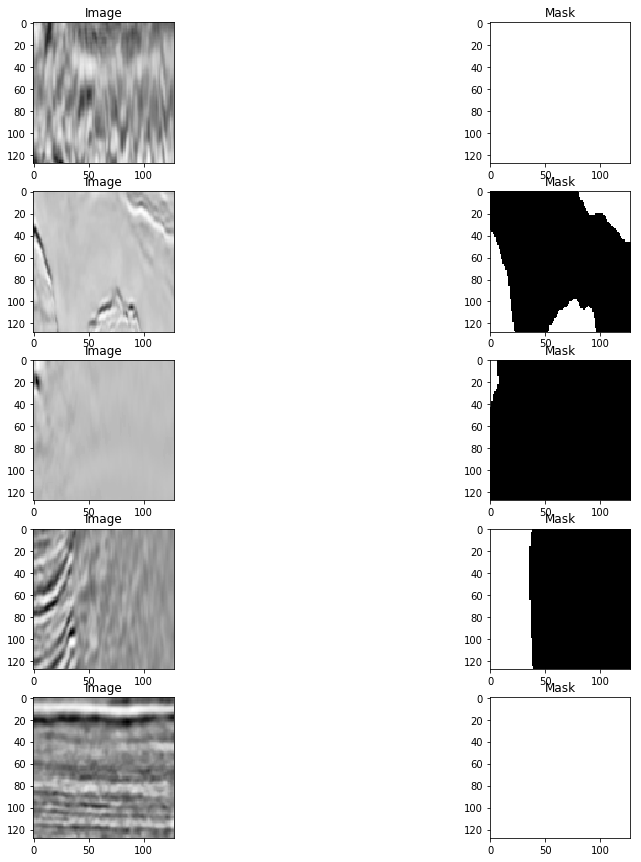

In [8]:
sample_batch = next(val_gen)
display_batch(sample_batch)

## Dummy Model

In [9]:
class TrainConfig:
    loss_func = None
    which_loss = 'map_iou'
    loss_at = False
    loss_log = False
    metrics = ["accuracy", iou, map_iou, slow_map_iou, get_map_iou_at(), get_map_iou_at(slow_map_iou)]
    
    # wrapper params
    wrapper_params = dict(
        protocol=0, pos_weight = .2, 
        neg_weight = .8, pen_no_mask=False
    )
    
    @property
    def get_loss(self):
        if self.loss_func:
            return self.loss_func
        return get_map_loss(self.which_loss, self.loss_at, self.loss_log)
    
    @property
    def get_wrapped_loss(self):
        return weight_loss_wrapper(self.get_loss, **self.wrapper_params)
    
T = TrainConfig()

In [10]:
input_layer = Input(TRAIN_IMG_SHAPE)
output_layer = unet_static(input_layer, 16)

model = Model(input_layer, output_layer)
metrics = T.metrics
metrics.extend([T.get_wrapped_loss])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

7

In [10]:
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00005, verbose=1)
history = model.fit_generator(
    train_gen, steps_per_epoch=125, 
    epochs=2, callbacks=[reduce_lr],
    validation_data=val_gen,
    validation_steps=125
)

Epoch 1/2
125/125 [==============================] - 199s 2s/step - loss: 0.5742 - acc: 0.7480 - iou: 0.0992 - map_iou: 0.0000e+00 - slow_map_iou: 0.3650 - map_iou_at: 0.0369 - map_iou_at_1: 0.2428 - weight_loss: 1.7419 - val_loss: 0.5438 - val_acc: 0.7527 - val_iou: 0.0952 - val_map_iou: 0.0000e+00 - val_slow_map_iou: 0.3867 - val_map_iou_at: 0.0354 - val_map_iou_at_1: 0.2659 - val_weight_loss: 1.6924
Epoch 2/2
125/125 [==============================] - 190s 2s/step - loss: 0.5142 - acc: 0.7556 - iou: 0.1065 - map_iou: 0.0000e+00 - slow_map_iou: 0.3915 - map_iou_at: 0.0445 - map_iou_at_1: 0.2725 - weight_loss: 1.6492 - val_loss: 0.4771 - val_acc: 0.7533 - val_iou: 0.1427 - val_map_iou: 0.0000e+00 - val_slow_map_iou: 0.3877 - val_map_iou_at: 0.0657 - val_map_iou_at_1: 0.2708 - val_weight_loss: 1.5883


In [10]:
from keras import backend as K
import tensorflow as tf

In [11]:
_ = K.eval

In [12]:
y_true = K.variable(sample_batch[1])
y_pred = K.variable(model.predict(sample_batch[0]))

def map_iou(y_true, y_pred):
    y_pred = K.round(y_pred)
    ious = iou(y_true, y_pred)

    def precision_at(threshold):
        mask = K.greater(ious, threshold)
        return mask

    precisions = [precision_at(t) for t in np.arange(0.5, 1.0, 0.05)]
    return K.mean(K.stack(precisions, axis=1))


def map_iou_at(y_true, y_pred, map_func=mean_score):
    map_ious = []
    for t in np.arange(0, 1.0, 0.05):
        y_pred_cast = K.cast(y_pred > t,  dtype='float32')
        map_ious.append(map_func(y_true, y_pred_cast))
    return K.mean(K.stack(map_ious))


In [168]:
_(tf.reduce_prod(tf.shape(y_true)[1:]))

16384

In [13]:
gt_sum = K.sum(y_true, axis=[1, 2, 3])
pred_sum = K.sum(y_pred, axis=[1, 2, 3])
diff = (pred_sum - gt_sum) / 16384
loss = diff ** 2
mask = diff < 0

_(tf.scatter_mul(tf.Variable(diff), tf.where(diff > 0), .2))

array([ 0.07899901, -0.39059824, -0.53224945, -0.3175785 ,  0.06034635,
        0.07633658,  0.07131092,  0.06142812, -0.03273627,  0.06698217,
        0.04900081,  0.04987723,  0.07663102,  0.05341348,  0.02563118,
        0.04727635,  0.0297737 ,  0.06774844,  0.07618618,  0.06038117,
        0.05643179,  0.0627163 ,  0.0542298 ,  0.04892599,  0.04299423,
        0.07119111,  0.06586877,  0.0503357 , -0.11891583,  0.07553346,
       -0.4536612 , -0.3332464 ], dtype=float32)

In [14]:
_(gt_sum)

array([0.0000e+00, 1.2875e+04, 1.6160e+04, 1.1711e+04, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 5.7000e+02, 4.2900e+03, 0.0000e+00,
       9.6600e+02, 0.0000e+00, 3.0000e+00, 0.0000e+00, 3.6210e+03,
       0.0000e+00, 1.7760e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.2600e+02, 1.0600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 8.9000e+01, 0.0000e+00, 7.8490e+03, 0.0000e+00,
       1.4458e+04, 1.2212e+04], dtype=float32)

In [15]:
gt_no_masks = tf.equal(gt_sum, 0.)
_(gt_no_masks)

array([ True, False, False, False,  True,  True,  True, False, False,
        True, False,  True, False,  True, False,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True, False,  True, False, False])

In [16]:
pred_has_mask = tf.greater(pred_sum, 0.)
_(pred_has_mask)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [31]:
should_not_have_mask = tf.cast(gt_no_masks, tf.float32) * tf.cast(pred_has_mask, tf.float32)
_(should_not_have_mask)

array([1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [36]:
_(loss)

array([0.15602107, 0.15256698, 0.28328946, 0.1008561 , 0.09104203,
       0.14568186, 0.12713115, 0.09433535, 0.00107166, 0.11216528,
       0.06002699, 0.06219345, 0.1468078 , 0.07132497, 0.01642393,
       0.05587633, 0.02216183, 0.11474627, 0.14510834, 0.09114715,
       0.07961367, 0.09833334, 0.07352178, 0.05984382, 0.04621258,
       0.12670434, 0.10846738, 0.06334206, 0.01414097, 0.14263259,
       0.20580848, 0.11105316], dtype=float32)

In [35]:
no_mask_weight = (should_not_have_mask * (pred_sum / 16384)) + 1
_(loss * no_mask_weight)

array([0.21764861, 0.15256698, 0.28328946, 0.1008561 , 0.1185123 ,
       0.20128612, 0.17246033, 0.09433535, 0.00107166, 0.14973065,
       0.06002699, 0.07770364, 0.1468078 , 0.09037355, 0.01642393,
       0.06908447, 0.02216183, 0.15361567, 0.20038459, 0.11866502,
       0.07961367, 0.09833334, 0.09345714, 0.07448341, 0.05614695,
       0.17180546, 0.10846738, 0.0792839 , 0.01414097, 0.19650026,
       0.20580848, 0.11105316], dtype=float32)

In [169]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [154]:
_(K.sum(y_pred, axis=[1, 2, 3]))

array([6084.764 , 6015.697 , 7248.4766, 6132.9844, 3890.0068, 5489.368 ,
       4765.5303, 4835.0625, 2688.4595, 4522.9556, 4105.3135, 2960.29  ,
       5594.318 , 3370.9595, 4931.496 , 2726.9548, 3182.5972, 4566.2593,
       5666.9307, 4135.109 , 4684.2275, 4213.071 , 3254.297 , 2967.4863,
       2629.1672, 5026.3296, 4572.218 , 2968.0112, 5186.0854, 5752.724 ,
       6730.312 , 6389.336 ], dtype=float32)

In [127]:
_(mean_score(y_true, K.cast(y_pred > 0.3, dtype='float32')))

0.13125

In [98]:
_(map_iou(y_true, y_pred))

0.0

In [71]:
_(iou(y_true, y_pred))

array([0.        , 0.80304945, 0.9736663 , 0.8891124 , 0.        ,
       0.        , 0.        , 0.01602395, 0.01391466, 0.        ,
       0.11764706, 0.        , 0.        , 0.        , 0.37860623,
       0.        , 0.41670293, 0.        , 0.        , 0.        ,
       0.0012053 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00160385, 0.        , 0.6654287 , 0.        ,
       0.887521  , 0.74347514], dtype=float32)

In [91]:
_(K.mean(map_iou(y_true, y_pred)))

0.0

In [48]:
model.predict(sample_batch[0]) > 0.3

array([[[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [False],
         ...,
         [ True],
         [ True],
         [ True]],

        ...,

        [[ True],
         [False],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [ True],
         [ True]]],


       [[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [ True],
         [ T

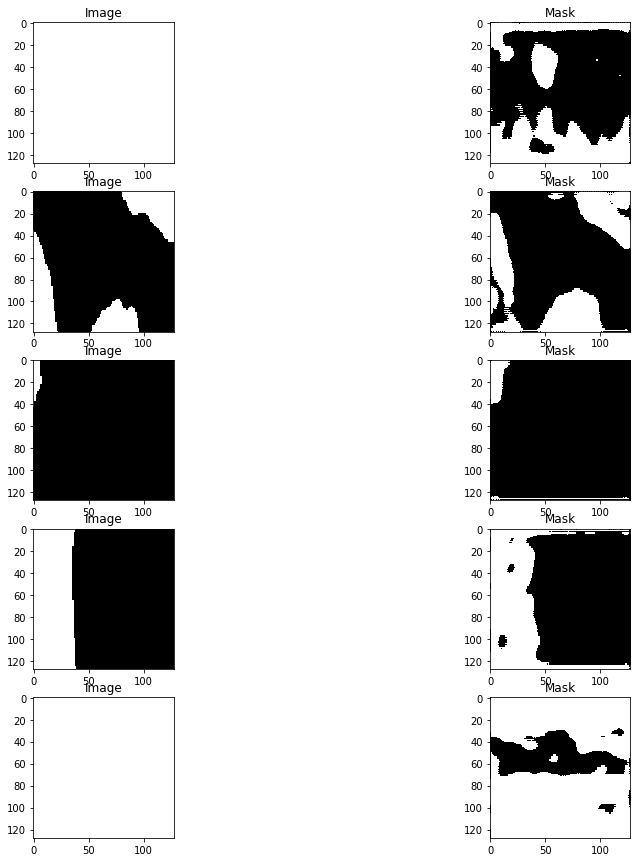

In [53]:
display_batch((sample_batch[1], (model.predict(sample_batch[0]) > 0.36).astype('float32')))

In [16]:
K.eval(K.mean(iou(y_true, y_pred), axis=0))

0.09094181

In [ ]:
K.eval(K.mean(K.variable(value=[K.mean(K.greater(iou(y_true, y_pred), 0.01)), K.mean(K.greater(iou(y_true, y_pred), 0.1))], name='precisions')))

intersections = y_true * y_pred
unions = (y_true + y_pred) - intersections
ious = iou(y_true, y_pred)

def _(var):
    return K.cast(var, dtype='float32')

mask = _(K.greater(ious, 0.1))

K.eval(intersections)

K.eval(ious).shape

K.eval(map_iou(y_true, y_pred))

y_pred